## Import libaries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.metrics import f1_score

## Import data

In [2]:
# Read from url - Take time to run
#url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
#df = pd.read_csv(url, compression='bz2')

# Read from drive
df = pd.read_csv('./temp/Airline.csv')

In [3]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
6744985,2008,12,20,6,850.0,850,1611.0,1604,DL,116,...,6.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2109876,2008,4,24,4,1838.0,1659,2101.0,1929,EV,4271,...,13.0,23.0,0,NaN,0,0.0,0.0,2.0,0.0,90.0
6737439,2008,12,14,7,625.0,630,1442.0,1504,DL,72,...,13.0,18.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5082679,2008,9,9,2,1759.0,1805,1908.0,1859,US,668,...,8.0,28.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6701093,2008,12,7,7,833.0,840,1034.0,1046,US,1575,...,4.0,15.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

## Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718291
CRSDepTime           1752432
ArrTime              1714414
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731437
ActualElapsedTime    1713645
CRSElapsedTime       1752223
AirTime              1713645
ArrDelay             1713645
DepDelay             1718291
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714414
TaxiOut              1718087
Cancelled            1752432
CancellationCode       34439
Diverted             1752432
CarrierDelay          380838
WeatherDelay          380838
NASDelay              380838
SecurityDelay         380838
LateAircraftDelay     380838
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime', 'DepDelay'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713645
DayofMonth        1713645
DayOfWeek         1713645
CRSArrTime        1713645
UniqueCarrier     1713645
CRSElapsedTime    1713645
AirTime           1713645
ArrDelay          1713645
Dest              1713645
Distance          1713645
TaxiIn            1713645
TaxiOut           1713645
dtype: int64

In [7]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [8]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
6744985,12,20,6,DL,254.0,236.0,7.0,ATL,1946,6.0,19.0,2,0
2109876,4,24,4,EV,150.0,107.0,92.0,ATL,780,13.0,23.0,3,1
6737439,12,14,7,DL,334.0,286.0,-22.0,JFK,2586,13.0,18.0,2,0
5082679,9,9,2,US,174.0,153.0,9.0,PHX,1044,8.0,28.0,3,0
6701093,12,7,7,US,126.0,102.0,-12.0,JAX,634,4.0,15.0,1,0


## Data analysis

In [11]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06,1.713645e+06
mean,6.389404e+00,1.573814e+01,3.924368e+00,1.290490e+02,1.039885e+02,8.151213e+00,7.285179e+02,6.860342e+00,1.643610e+01,2.243301e+00,1.312979e-01
std,3.398343e+00,8.799558e+00,1.988695e+00,6.953425e+01,6.743185e+01,3.850170e+01,5.631492e+02,4.917721e+00,1.129944e+01,1.019046e+00,3.377260e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.410000e+02,0.000000e+00,-9.100000e+01,3.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.500000e+01,-1.000000e+01,3.260000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,8.230000e+02,2.461000e+03,4.962000e+03,2.070000e+02,4.220000e+02,4.000000e+00,1.000000e+00


In [12]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,0.000254,-0.004606,-0.007190,-0.013287,-0.042270,-0.006517,0.007094,-0.017300,-0.006951,-0.036036
DayofMonth,0.000254,1.000000,0.005324,0.000734,0.000226,0.002507,0.000575,-0.002764,0.000354,-0.001057,0.000431
DayOfWeek,-0.004606,0.005324,1.000000,0.015259,0.014178,0.010682,0.016987,0.010395,-0.006450,0.002943,0.010763
CRSElapsedTime,-0.007190,0.000734,0.015259,1.000000,0.988207,0.012352,0.983211,0.104445,0.143191,0.090953,0.030587
AirTime,-0.013287,0.000226,0.014178,0.988207,1.000000,0.034368,0.982949,0.085251,0.108254,0.077875,0.040540
ArrDelay,-0.042270,0.002507,0.010682,0.012352,0.034368,1.000000,0.006273,0.123734,0.321629,0.115298,0.739362
Distance,-0.006517,0.000575,0.016987,0.983211,0.982949,0.006273,1.000000,0.077286,0.091296,0.090831,0.018502
TaxiIn,0.007094,-0.002764,0.010395,0.104445,0.085251,0.123734,0.077286,1.000000,0.040645,-0.019767,0.089186
TaxiOut,-0.017300,0.000354,-0.006450,0.143191,0.108254,0.321629,0.091296,0.040645,1.000000,0.057671,0.290987
PotD,-0.006951,-0.001057,0.002943,0.090953,0.077875,0.115298,0.090831,-0.019767,0.057671,1.000000,0.134123


In [13]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,
9E,6.508830,15.710656,3.917730,100.307617,71.088948,4.083779,450.503237,8.524967,18.162089,2.187606,0.106137
AA,6.448441,15.749048,3.955723,167.580458,141.825210,12.488876,1056.415599,8.239913,16.854218,2.323074,0.170648
AQ,1.472370,15.199256,3.921360,74.504251,61.353879,-3.032944,419.188629,3.826249,8.139214,2.171626,0.019660
AS,6.394660,15.695501,3.943370,155.158461,131.920864,4.660357,961.840383,5.790368,15.563903,2.338864,0.106940
B6,6.426109,15.839403,3.994177,179.447334,149.851821,11.218512,1097.463988,6.260837,21.671272,2.349118,0.168757
CO,6.304511,15.794810,3.912320,186.782570,156.169737,10.728451,1158.209874,7.955153,20.449836,2.306580,0.151561
DL,6.499811,15.736328,3.913950,156.456777,127.085114,7.754098,925.971368,8.654475,20.579818,2.252774,0.117313
EV,6.478889,15.738267,3.923364,95.694039,69.923059,10.200000,443.831186,7.329107,16.680881,2.104173,0.148822
F9,6.470117,15.721733,3.948250,143.297532,121.608705,6.026987,879.143079,7.373374,14.527155,2.334676,0.090699


In [14]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,
ABE,6.552677,15.825561,3.807427,100.449050,73.376511,9.601036,532.219344,4.576857,20.109672,2.772021,0.158895
ABI,6.544000,15.619200,4.038400,53.196800,33.345600,9.788800,158.000000,3.641600,15.947200,2.710400,0.140800
ABQ,6.392839,15.731231,3.922047,114.194089,92.288307,5.851830,652.511455,5.282257,13.478727,2.271546,0.108103
ABY,6.254545,16.083636,3.869091,54.192727,27.545455,8.207273,146.000000,3.480000,23.112727,2.560000,0.141818
ACK,7.138614,16.504950,4.128713,86.524752,45.237624,18.267327,207.148515,5.762376,36.277228,2.237624,0.287129
ACT,5.931416,15.254425,3.853982,45.081858,23.672566,5.486726,89.000000,4.898230,15.550885,2.201327,0.112832
ACV,6.625138,15.972437,3.807056,75.787211,55.963616,13.448732,258.707828,4.434399,16.379272,2.401323,0.174201
ACY,2.541667,15.000000,3.583333,114.083333,88.083333,6.291667,678.000000,3.583333,21.083333,3.000000,0.125000
ADK,7.600000,16.760000,5.560000,190.600000,175.280000,8.760000,1192.000000,4.440000,11.640000,2.640000,0.120000


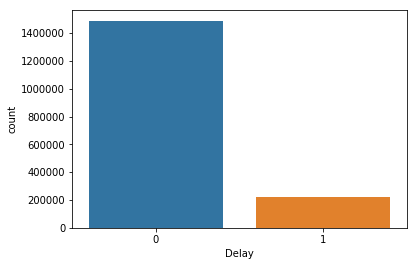

In [15]:
# Bias check
sns.countplot(x="Delay", data=df)

In [16]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

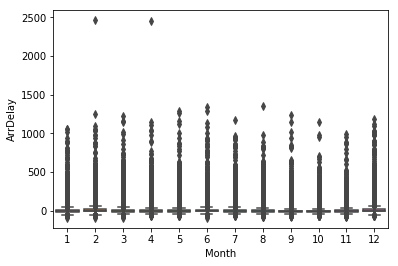

In [17]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [18]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.119418

#### DayofMonth

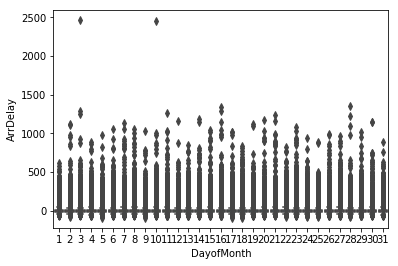

In [19]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [20]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.036635

#### Weekend

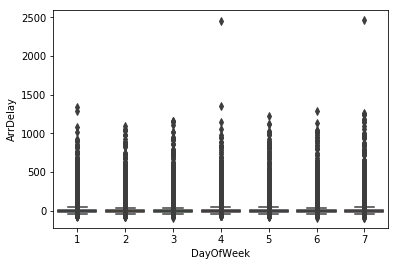

In [21]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [22]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.036781

#### Parts of the Day

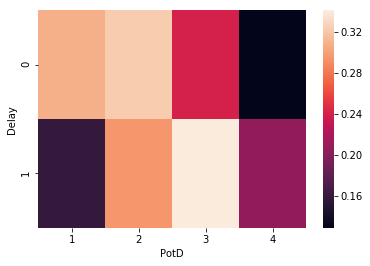

In [23]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [24]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.136395

## Model evaluation
We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

In [25]:
# Create a copy of original dataset
df_backup = df.copy()

### Logistic Regression

In [ ]:
df = df_backup.copy()

One-hot encoding

In [ ]:
# Dest column
df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

# UniqueCarrier column
df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

Holdout

In [ ]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

Default parameters

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : [1, 5, 10]}

model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = grid, cv = 3, scoring = 'f1', n_jobs = -1)

model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

Tune hyper parameters using 3-values-method, with f1 metric.

### Naive Bayes

In [26]:
df = df_backup.copy()

Label encoder

In [27]:
from sklearn.preprocessing import LabelEncoder

# Dest column
df['Dest'] = LabelEncoder().fit_transform(df['Dest'])

# UniqueCarrier column
df['UniqueCarrier'] = LabelEncoder().fit_transform(df['UniqueCarrier'])

Holdout

In [28]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [29]:
X_train.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,Dest,Distance,TaxiIn,TaxiOut,PotD
3710883,7,21,1,18,90.0,50.0,243,246,7.0,25.0,3
5763188,10,31,5,11,65.0,39.0,210,196,9.0,6.0,3
3518647,6,3,2,1,245.0,226.0,210,1726,26.0,30.0,2
6418924,11,16,7,4,146.0,115.0,150,944,10.0,15.0,1
3837282,7,23,3,15,169.0,146.0,64,1155,5.0,20.0,3


Default parameters

In [30]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    297712
           1       0.43      0.23      0.30     45017

   micro avg       0.86      0.86      0.86    342729
   macro avg       0.66      0.59      0.61    342729
weighted avg       0.83      0.86      0.84    342729



### Random Forest
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

Default parameters

In [35]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.89      0.99      0.94    297712
           1       0.71      0.17      0.27     45017

   micro avg       0.88      0.88      0.88    342729
   macro avg       0.80      0.58      0.60    342729
weighted avg       0.86      0.88      0.85    342729



Hyperparameter tuning

1  done!
3  done!
5  done!
7  done!
9  done!
11  done!
13  done!
15  done!
20  done!
25  done!


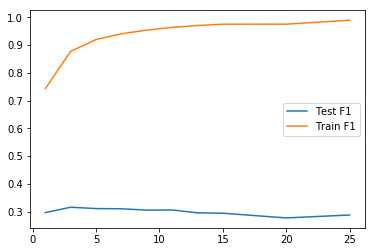

In [32]:
# n_estimators
n_estimators = [1, 3, 5, 7, 9, 11, 13, 15, 20, 25]
test_results = []
train_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1, class_weight = 'balanced')
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    train_pred = model.predict(X_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)

    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results, label='Test F1')
sns.lineplot(x = n_estimators, y = train_results, label='Train F1')

/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


8.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


11.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


14.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


17.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


20.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


23.0  done!


/home/npqbuu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


26.0  done!


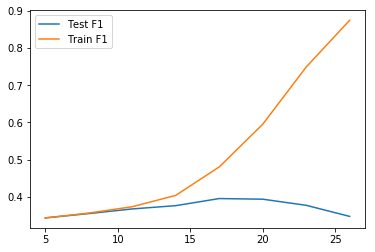

In [33]:
# max_depths
max_depths = np.linspace(5, 26, 8)
test_results = []
train_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth = max_depth, n_jobs = -1, class_weight = 'balanced')
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    train_pred = model.predict(X_train)
    f1 = f1_score(y_train, train_pred)
    train_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results, label='Test F1')
sns.lineplot(x = max_depths, y = train_results, label='Train F1')

**Final model**

Best parameters:
- n_estimators = 3
- max_depths = 17

In [34]:
model = RandomForestClassifier(n_estimators = 3, max_depth = 17, n_jobs = -1, class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.77      0.84    297712
           1       0.27      0.57      0.37     45017

   micro avg       0.74      0.74      0.74    342729
   macro avg       0.60      0.67      0.61    342729
weighted avg       0.84      0.74      0.78    342729



# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall (F1 score)
5. Compare performances among models